In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
titanic_data = pd.read_csv('data/train.csv')

In [8]:
titanic_data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


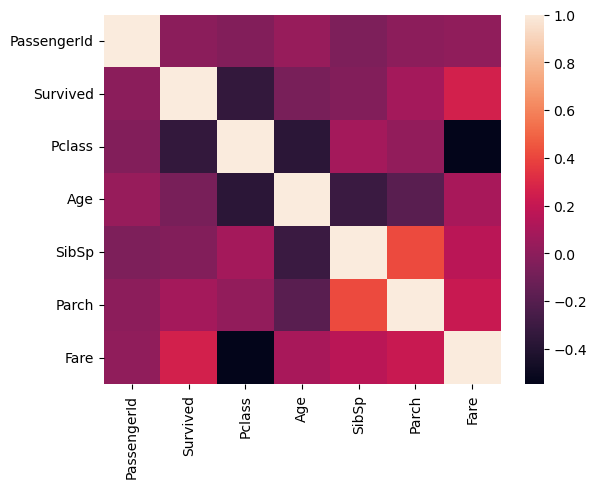

In [13]:
sns.heatmap(titanic_data.corr(numeric_only=True))
plt.show()

# Initial Observations:
    - Survived high corr with Pclass
    - Pclass high corr with Age and Fare

In [14]:
from sklearn.model_selection import StratifiedShuffleSplit

In [17]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2)
for train_indices, test_indices in split.split(titanic_data, titanic_data[["Survived", "Pclass", "Sex"]]):
    strat_train_set = titanic_data.loc[train_indices]
    strat_test_set = titanic_data.loc[test_indices]

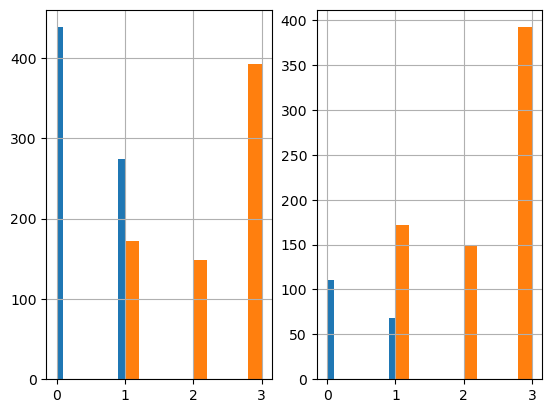

In [18]:
plt.subplot(1,2,1)
strat_train_set['Survived'].hist()
strat_train_set['Pclass'].hist()

plt.subplot(1,2,2)
strat_test_set['Survived'].hist()
strat_train_set['Pclass'].hist()

plt.show()

In [19]:
strat_train_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 712 entries, 837 to 500
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  712 non-null    int64  
 1   Survived     712 non-null    int64  
 2   Pclass       712 non-null    int64  
 3   Name         712 non-null    object 
 4   Sex          712 non-null    object 
 5   Age          574 non-null    float64
 6   SibSp        712 non-null    int64  
 7   Parch        712 non-null    int64  
 8   Ticket       712 non-null    object 
 9   Fare         712 non-null    float64
 10  Cabin        161 non-null    object 
 11  Embarked     710 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 72.3+ KB


# Dealing With Missing Data
Using impute to add neutral values to missing age data

In [34]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer

class AgeImputer(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        imputer = SimpleImputer(strategy="mean")
        X['Age'] = imputer.fit_transform(X[['Age']])
        return X

# Hot Encoding
Converting to binary features

In [35]:
from sklearn.preprocessing import OneHotEncoder

class FeatureEncoder(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        encoder = OneHotEncoder()
        matrix= encoder.fit_transform(X[['Embarked']]).toarray()
                                      
        column_names = ["C", "S", "Q", "N"]
        
        for i in range(len(matrix.T)):
            X[column_names[i]] = matrix.T[i]
        
        matrix = encoder.fit_transform(X[['Sex']]).toarray()
                                      
        column_names = ["Female", "Male"]
        
        for i in range(len(matrix.T)):
            X[column_names[i]] = matrix.T[i]
        return X

In [36]:
class FeatureDropper(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X.drop(["Embarked","Name","Ticket","Cabin","Sex","N"], axis=1, errors="ignore")

In [37]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([("ageimputer", AgeImputer()), ("featureencoder", FeatureEncoder()), ("featuredropper", FeatureDropper())])

In [38]:
strat_train_set = pipeline.fit_transform(strat_train_set)

In [40]:
strat_train_set

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,C,S,Q,Female,Male
837,838,0,3,29.593345,0,0,8.0500,0.0,0.0,1.0,0.0,1.0
165,166,1,3,9.000000,0,2,20.5250,0.0,0.0,1.0,0.0,1.0
226,227,1,2,19.000000,0,0,10.5000,0.0,0.0,1.0,0.0,1.0
778,779,0,3,29.593345,0,0,7.7375,0.0,1.0,0.0,0.0,1.0
266,267,0,3,16.000000,4,1,39.6875,0.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
117,118,0,2,29.000000,1,0,21.0000,0.0,0.0,1.0,0.0,1.0
807,808,0,3,18.000000,0,0,7.7750,0.0,0.0,1.0,1.0,0.0
62,63,0,1,45.000000,1,0,83.4750,0.0,0.0,1.0,0.0,1.0
145,146,0,2,19.000000,1,1,36.7500,0.0,0.0,1.0,0.0,1.0


In [41]:
strat_train_set.info

<bound method DataFrame.info of      PassengerId  Survived  Pclass        Age  SibSp  Parch     Fare    C  \
837          838         0       3  29.593345      0      0   8.0500  0.0   
165          166         1       3   9.000000      0      2  20.5250  0.0   
226          227         1       2  19.000000      0      0  10.5000  0.0   
778          779         0       3  29.593345      0      0   7.7375  0.0   
266          267         0       3  16.000000      4      1  39.6875  0.0   
..           ...       ...     ...        ...    ...    ...      ...  ...   
117          118         0       2  29.000000      1      0  21.0000  0.0   
807          808         0       3  18.000000      0      0   7.7750  0.0   
62            63         0       1  45.000000      1      0  83.4750  0.0   
145          146         0       2  19.000000      1      1  36.7500  0.0   
500          501         0       3  17.000000      0      0   8.6625  0.0   

       S    Q  Female  Male  
837  0.0  1.0

# Scalar and Model Selection
Preprocessing data, then training RFC model

In [43]:
from sklearn.preprocessing import StandardScaler
X = strat_train_set.drop(['Survived'], axis=1)
y=strat_train_set['Survived']
scaler = StandardScaler()
X_data = scaler.fit_transform(X)
y_data = y.to_numpy()

In [44]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

clf = RandomForestClassifier()

param_grid = [
    {"n_estimators": [10,100,200,500], "max_depth": [None, 5, 10], "min_samples_split": [2,3,4]}
]

grid_search = GridSearchCV(clf, param_grid, cv=3, scoring="accuracy", return_train_score=True)
grid_search.fit(X_data, y_data)

GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid=[{'max_depth': [None, 5, 10],
                          'min_samples_split': [2, 3, 4],
                          'n_estimators': [10, 100, 200, 500]}],
             return_train_score=True, scoring='accuracy')

In [45]:
final_clf = grid_search.best_estimator_
final_clf

RandomForestClassifier(min_samples_split=4, n_estimators=200)

In [46]:
strat_test_set = pipeline.fit_transform(strat_test_set)

In [47]:
strat_test_set

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,C,S,Q,Female,Male
154,155,0,3,30.132786,0,0,7.3125,0.0,0.0,1.0,0.0,1.0
159,160,0,3,30.132786,8,2,69.5500,0.0,0.0,1.0,0.0,1.0
681,682,1,1,27.000000,0,0,76.7292,1.0,0.0,0.0,0.0,1.0
95,96,0,3,30.132786,0,0,8.0500,0.0,0.0,1.0,0.0,1.0
343,344,0,2,25.000000,0,0,13.0000,0.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
524,525,0,3,30.132786,0,0,7.2292,1.0,0.0,0.0,0.0,1.0
788,789,1,3,1.000000,1,2,20.5750,0.0,0.0,1.0,0.0,1.0
353,354,0,3,25.000000,1,0,17.8000,0.0,0.0,1.0,0.0,1.0
855,856,1,3,18.000000,0,1,9.3500,0.0,0.0,1.0,1.0,0.0


In [52]:
X_test = strat_test_set.drop(['Survived'], axis=1)
y_test = strat_test_set['Survived']

scaler= StandardScaler()
X_data_test = scaler.fit_transform(X_test)
y_data_test = y_test.to_numpy()

In [53]:
final_clf.score(X_data_test, y_data_test)

0.8156424581005587

In [54]:
final_data = pipeline.fit_transform(titanic_data)

In [55]:
final_data

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,C,S,Q,Female,Male
0,1,0,3,22.000000,1,0,7.2500,0.0,0.0,1.0,0.0,1.0
1,2,1,1,38.000000,1,0,71.2833,1.0,0.0,0.0,1.0,0.0
2,3,1,3,26.000000,0,0,7.9250,0.0,0.0,1.0,1.0,0.0
3,4,1,1,35.000000,1,0,53.1000,0.0,0.0,1.0,1.0,0.0
4,5,0,3,35.000000,0,0,8.0500,0.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,27.000000,0,0,13.0000,0.0,0.0,1.0,0.0,1.0
887,888,1,1,19.000000,0,0,30.0000,0.0,0.0,1.0,1.0,0.0
888,889,0,3,29.699118,1,2,23.4500,0.0,0.0,1.0,1.0,0.0
889,890,1,1,26.000000,0,0,30.0000,1.0,0.0,0.0,0.0,1.0


In [61]:
X_final = final_data.drop(['Survived'], axis=1)
y_final = final_data['Survived']

scaler = StandardScaler()
X_data_final = scaler.fit_transform(X_final)
y_data_final = y_final.to_numpy()

In [62]:
prod_clf = RandomForestClassifier()

param_grid = [
    {"n_estimators": [10,100,200,500], "max_depth": [None, 5, 10], "min_samples_split": [2,3,4]}
]

grid_search = GridSearchCV(prod_clf, param_grid, cv=3, scoring="accuracy", return_train_score=True)
grid_search.fit(X_data_final, y_data_final)

GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid=[{'max_depth': [None, 5, 10],
                          'min_samples_split': [2, 3, 4],
                          'n_estimators': [10, 100, 200, 500]}],
             return_train_score=True, scoring='accuracy')

In [66]:
prod_final_clf = grid_search.best_estimator_

In [70]:
titanic_test_data = pd.read_csv("data/test.csv")

In [73]:
final_test_data = pipeline.fit_transform(titanic_test_data)

In [76]:
final_test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Age          418 non-null    float64
 3   SibSp        418 non-null    int64  
 4   Parch        418 non-null    int64  
 5   Fare         417 non-null    float64
 6   C            418 non-null    float64
 7   S            418 non-null    float64
 8   Q            418 non-null    float64
 9   Female       418 non-null    float64
 10  Male         418 non-null    float64
dtypes: float64(7), int64(4)
memory usage: 36.1 KB


In [77]:
X_final_test = final_test_data
X_final_test = X_final_test.fillna(method="ffill")

scaler = StandardScaler()
X_data_final_test = scaler.fit_transform(X_final_test)

C:\Users\hampt\AppData\Local\Temp\ipykernel_27912\1896703401.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X_final_test = X_final_test.fillna(method="ffill")


In [78]:
predictions = prod_final_clf.predict(X_data_final_test)

In [79]:
predictions

array([0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

# Save and Submit

In [82]:
final_df = pd.DataFrame(titanic_test_data['PassengerId'])
final_df['Survived'] = predictions
final_df.to_csv("data/predictions.csv", index=False)

In [83]:
final_df

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0
